In [1]:
from pathlib import Path
from natsort import natsorted
from ast import literal_eval
import numpy as np
from skimage.io import imread
import napari
import pandas as pd
from skimage.measure import regionprops
from tqdm.auto import tqdm
import zarr
import dask.array as da
import numpy as np
import dask.array as da
from tqdm.auto import tqdm
from cellpose import models
from skimage.registration import phase_cross_correlation
from scipy.ndimage import fourier_shift
from scipy.ndimage import shift as ndi_shift
from collections import defaultdict
import numpy as np

def compute_shift_observed(fiducials):
    """
    Compute average (Δy, Δx) shift between the first two frames in a fiducial array.

    Parameters
    ----------
    fiducials : np.ndarray
        Array of shape (N, 3) with columns [frame, y, x].

    Returns
    -------
    shift_observed : np.ndarray
        Array of shape (2,) giving [Δy, Δx] from first to second frame.
    """
    # Identify unique sorted frame indices
    frames = np.unique(fiducials[:, 0])
    if len(frames) < 2:
        raise ValueError("At least two frames are required to compute shift.")

    # Extract coordinates for first and second frame
    pts1 = fiducials[fiducials[:, 0] == frames[0]][:, 1:]
    pts2 = fiducials[fiducials[:, 0] == frames[1]][:, 1:]

    if pts1.shape != pts2.shape:
        raise ValueError(f"Fiducial count mismatch between frames {frames[0]} and {frames[1]}.")

    # Compute average displacement
    shift_observed = np.mean(pts2 - pts1, axis=0)  # [Δy, Δx]
    return shift_observed




Welcome to CellposeSAM, cellpose v4.0.1! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




#### Free up memory

In [263]:
import sys

# Get a dictionary of all variables in the current scope
all_vars = globals().copy()

# Remove built-in variables and some special ones
to_exclude = ['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__']
vars_to_check = {k: v for k, v in all_vars.items() if not k.startswith('_') and k not in to_exclude}

# Function to get the size of an object in bytes
def get_size(obj):
    return sys.getsizeof(obj)

# Get the size of each variable
var_sizes = [(k, get_size(v)) for k, v in vars_to_check.items()]

# Sort by size in descending order
sorted_vars = sorted(var_sizes, key=lambda item: item[1], reverse=True)

# Print the largest variables
print("Largest variables in memory:")
for name, size in sorted_vars[:10]:  # Display the top 10 largest
    print(f"{name}: {size / (1024 * 1024):.2f} MB")

Largest variables in memory:
segmentation_shifted_loaded: 19130.71 MB
all_aligned_tracks: 21.37 MB
aligned_live_2_tracks: 16.11 MB
live_2_tracks: 14.53 MB
napari_tracks: 8.42 MB
live_1_tracks: 5.26 MB
aligned_live_1_tracks: 5.26 MB
extended_tracks_df: 1.58 MB
final_tracks: 0.10 MB
df: 0.10 MB


In [262]:
fixed_frames_loaded = padded = None

# Launch napari

In [3]:
viewer = napari.Viewer(title = 'linking')

## Load live-cell 1

In [264]:
zarr_dir = Path('/mnt/DATA3/BPP0050/live_1.zarr/3_4')

In [265]:
zarr_root = zarr.open_group(zarr_dir, mode='r')

In [266]:
live_1_images = da.asarray(zarr_root["images"]["0"].images)

In [267]:
live_1_images

dask.array<array, shape=(48, 3, 3, 6911, 6911), dtype=uint16, chunksize=(48, 3, 3, 394, 394), chunktype=numpy.ndarray>

In [268]:
live_1_segmentation = da.asarray(zarr_root["labels"]["trackastra_labels"]["0"])

In [269]:
live_1_segmentation

dask.array<array, shape=(48, 6911, 6911), dtype=uint16, chunksize=(1, 6911, 6911), chunktype=numpy.ndarray>

In [270]:
tracks_path = Path(zarr_dir / 'labels/trackastra_labels/tables/track/')
# Load and filter track table
track_columns = [f.name for f in tracks_path.iterdir() if f.is_dir()]
track_data = {
    col: zarr.open(tracks_path / col, mode='r')[:]
    for col in track_columns
}
live_1_tracks = pd.DataFrame(track_data)
live_1_tracks

,parent_track_id,area,t,x,y,label_id,mtb_load,track_id,dpc_load
0,-1,12652,0,2662.854252,5497.791179,1,2542775,1,34246525
1,-1,7504,0,2812.134861,4324.219749,2,1356867,2,23240358
2,-1,15763,0,4836.058047,6580.739263,3,2683253,3,34782336
3,-1,12417,0,4121.685029,5246.592816,4,2099658,4,46718252
4,-1,13148,0,2612.493839,2841.209614,5,2497857,5,58153179
...,...,...,...,...,...,...,...,...,...
83598,-1,10212,47,3623.432628,2670.368292,5964,1829053,5964,36975417
83599,-1,8049,47,3897.397068,2651.235184,5965,1191337,5965,20857625
83600,-1,14717,47,2989.994836,1531.412516,5966,1982177,5966,35345109
83601,-1,9928,47,1676.677176,2526.716156,5967,1787746,5967,31161161


## Load live-cell 2

In [271]:
zarr_dir = Path('/mnt/DATA3/BPP0050/live_2.zarr/3_4') 

In [272]:
zarr_root = zarr.open_group(zarr_dir, mode='r')

In [273]:
live_2_images = da.asarray(zarr_root["images"]["0"].images) 

In [274]:
live_2_images

dask.array<array, shape=(144, 3, 3, 6911, 6911), dtype=uint16, chunksize=(1, 1, 1, 6911, 6911), chunktype=numpy.ndarray>

In [275]:
live_2_segmentation = da.asarray(zarr_root["labels"]["trackastra_labels"]["0"])

In [276]:
live_2_segmentation

dask.array<array, shape=(144, 6911, 6911), dtype=uint16, chunksize=(1, 6911, 6911), chunktype=numpy.ndarray>

In [277]:
tracks_path = Path(zarr_dir / 'labels/trackastra_labels/tables/track/')
# Load and filter track table
track_columns = [f.name for f in tracks_path.iterdir() if f.is_dir()]
track_data = {
    col: zarr.open(tracks_path / col, mode='r')[:]
    for col in track_columns
}
live_2_tracks = pd.DataFrame(track_data)
live_2_tracks

,parent_track_id,area,t,x,y,label_id,mtb_load,track_id,dpc_load
0,-1,9387,0,31.385746,5255.777991,1,1201504,1,24126631
1,-1,9440,0,1047.168962,4309.270233,2,1312296,2,40037906
2,-1,8870,0,1783.673506,6162.008906,3,1757239,3,21841336
3,-1,8949,0,3918.382613,5712.438485,4,1286528,4,34700559
4,-1,40809,0,1285.942464,3491.259600,5,6825908,5,76649705
...,...,...,...,...,...,...,...,...,...
230869,-1,7091,143,3456.288535,6434.239035,10176,1244033,10176,28135453
230870,-1,6467,143,357.469615,1336.872275,10177,1223056,10177,26782538
230871,-1,4181,143,2424.196365,27.717293,10178,657971,10178,7977657
230872,-1,8490,143,1607.197173,1181.461131,10179,1408700,10179,47161095


## Load multiplexed images

In [278]:
zarr_dir = Path('/mnt/DATA3/BPP0050/multiplexed.zarr/3_4')

In [279]:
zarr_group = zarr.open_group(zarr_dir)

In [280]:
multiplex_images = da.asarray(zarr_group.images)[:,0,...] # isolate pseudo time point

In [281]:
multiplex_images

dask.array<getitem, shape=(17, 4, 8, 6911, 6911), dtype=uint16, chunksize=(1, 4, 8, 1448, 1448), chunktype=numpy.ndarray>

### Load intermediate frame

In [282]:
# Set the path to the Zarr store
zarr_path = Path("/mnt/DATA3/BPP0050/BPP0050-1-Live-cell-to4i_Fixed_Cy1__2025-04-14T16_57_11-Measurement 1/acquisition/zarr/(3, 4).zarr")

# Open the Zarr group and load the image array
zarr_group = zarr.open_group(zarr_path, mode='r')
intermediate_frame = da.asarray(zarr_group['images'])

In [283]:
# drop two unnecessary channels for simplicity of integration
intermediate_frame = intermediate_frame[:, [0, 1, 2, 5], :, :, :]

In [284]:
intermediate_frame

dask.array<getitem, shape=(1, 4, 3, 6911, 6911), dtype=uint16, chunksize=(1, 4, 3, 1930, 1930), chunktype=numpy.ndarray>

## Concatenate the 2 live cell imagery with the fixed imagery

In [285]:
live_images = da.concatenate([live_1_images, live_2_images], axis = 0)
live_images

dask.array<concatenate, shape=(192, 3, 3, 6911, 6911), dtype=uint16, chunksize=(48, 1, 1, 394, 394), chunktype=numpy.ndarray>

#### Flatten along Z

In [286]:
live_images = live_images.max(axis=2)
intermediate_frame = intermediate_frame.max(axis=2)
multiplex_images = multiplex_images.max(axis=2)
print(live_images.shape, intermediate_frame.shape, multiplex_images.shape)

(192, 3, 6911, 6911) (1, 4, 6911, 6911) (17, 4, 6911, 6911)


#### Create a blank 4th channel lazily for the live-cell to match the fixed shape

In [287]:
blank_channel = da.zeros((live_images.shape[0], 1, *live_images.shape[-2:]),
                         dtype=live_images.dtype)

# Concatenate it to the existing live images
live_images = da.concatenate([live_images, blank_channel], axis=1)

In [288]:
print(live_images.shape, intermediate_frame.shape, multiplex_images.shape)

(192, 4, 6911, 6911) (1, 4, 6911, 6911) (17, 4, 6911, 6911)


In [289]:
images = da.concatenate([live_images, intermediate_frame, multiplex_images])
images

dask.array<concatenate, shape=(210, 4, 6911, 6911), dtype=uint16, chunksize=(48, 1, 394, 394), chunktype=numpy.ndarray>

## Concatenate the segmentation and extend over the multiplexed data

In [290]:
live_segmentation = da.concatenate([live_1_segmentation, live_2_segmentation])
live_segmentation

dask.array<concatenate, shape=(192, 6911, 6911), dtype=uint16, chunksize=(1, 6911, 6911), chunktype=numpy.ndarray>

In [291]:
segmentation = da.concatenate([live_segmentation, da.repeat(live_segmentation[-1:], # extend the last cytoplasmic segmentation across the multiplex
                                                            images.shape[0] - live_segmentation.shape[0], # extend segmentation by this amount
                                                            axis=0)])
segmentation

dask.array<concatenate, shape=(210, 6911, 6911), dtype=uint16, chunksize=(18, 6911, 6911), chunktype=numpy.ndarray>

### Load into memory

In [292]:
images = images.rechunk((10, 4, 1024, 1024))
images

dask.array<rechunk-merge, shape=(210, 4, 6911, 6911), dtype=uint16, chunksize=(10, 4, 1024, 1024), chunktype=numpy.ndarray>

In [293]:
%%time
images = images.compute()


KeyboardInterrupt



In [35]:
images.shape

(210, 4, 6911, 6911)

In [36]:
viewer.add_image(images, channel_axis=1)

[<Image layer 'Image' at 0x7f607ce03370>,
 <Image layer 'Image [1]' at 0x7f606f657e80>,
 <Image layer 'Image [2]' at 0x7f606f68bfa0>,
 <Image layer 'Image [3]' at 0x7f606f6ecee0>]

In [61]:
segmentation = segmentation.rechunk((1, -1, -1))  # one frame at a time
segmentation

dask.array<rechunk-merge, shape=(210, 6911, 6911), dtype=uint16, chunksize=(1, 6911, 6911), chunktype=numpy.ndarray>

In [33]:
%%time
segmentation = segmentation.compute()

CPU times: user 37.8 s, sys: 10.8 s, total: 48.6 s
Wall time: 8.59 s


In [34]:
viewer.add_labels(segmentation)

<Labels layer 'segmentation' at 0x7fba049749d0>

# Automatically calculate the shifts between fixed frames
Using segmentation of dapi channel and the nuclei as fiducials.

In [66]:
# Set the DAPI channel
dapi_channel = -1

# Load Cellpose model with GPU
cellpose_model = models.CellposeModel(gpu=True)

In [84]:
# Get only the DAPI frames 192–209
dapi_stack = images[192:210, dapi_channel, 2943:3967, 2943:3967] # 1024×1024 center crop,  might need to edit this when i crop later on...?

# Initialize and compute segmentation-based shifts
alignment_segmentations = []
frame_shifts = []

for i, img in enumerate(tqdm(dapi_stack, desc="Segmenting and aligning")):
    masks, *_ = cellpose_model.eval(img)
    alignment_segmentations.append(masks)

    if i > 0:
        shift, _, _ = phase_cross_correlation(alignment_segmentations[i - 1], masks, upsample_factor=10)
        frame_shifts.append(shift)
    else:
        frame_shifts.append(np.array([0.0, 0.0]))

# Store directly as full-frame shift array
fixed_shifts = np.zeros((210, 2), dtype=np.float32)
fixed_shifts[192:210] = np.cumsum(frame_shifts, axis=0)

print('Fixed shifts:', fixed_shifts[192:210])

Segmenting and aligning:   0%|          | 0/18 [00:00<?, ?it/s]

Fixed shifts: [[ 0.000000e+00  0.000000e+00]
 [-3.900000e+00  0.000000e+00]
 [-4.000000e+00 -3.800000e+00]
 [ 1.460000e+01 -1.040000e+01]
 [ 1.060000e+01  4.200000e+00]
 [ 9.130000e+01  4.210000e+01]
 [ 1.300000e+00 -1.540000e+01]
 [ 1.880000e+01  9.200000e+00]
 [ 2.800000e+00 -9.000000e-01]
 [ 1.347000e+02  8.720000e+01]
 [ 6.880000e+01  3.590000e+01]
 [ 1.287000e+02  6.800000e+01]
 [ 6.700000e+00  3.200000e+00]
 [ 4.000000e+00 -2.100000e+00]
 [ 1.687539e-14 -1.200000e+00]
 [-5.800000e+00 -1.200000e+00]
 [ 8.100000e+00  4.200000e+00]
 [ 1.770000e+01  2.100000e+00]]


### Inspect the automatically calculated shifts

In [67]:
aligned_stack = np.empty_like(dapi_stack)

for i, (img, (dy, dx)) in enumerate(zip(dapi_stack, fixed_shifts[192:210])):
    aligned_stack[i] = ndi_shift(img, shift=(dy, dx), order=1, mode='nearest')

In [60]:
dapi_seg = np.stack(alignment_segmentations, axis=0)

In [61]:
v = napari.Viewer(title='testing auto alignemtn for multiplex')
v.add_image(dapi_stack)
v.add_labels(dapi_seg)

<Labels layer 'dapi_seg' at 0x7f5fe8f97400>

In [68]:
v.add_image(aligned_stack)

<Image layer 'aligned_stack' at 0x7f6011d6fe50>

### Annotate the larger shifts between live cell imaging rounds

By initialising a 3D (0, 3) points layer in the napari viewer and adding a couple of reference points between frames of interest

In [42]:
viewer.layers['fiducials'].data

array([[  47.        , 3222.14306624, 3368.90265877],
       [  48.        , 2994.20432992, 2616.17473885],
       [  47.        , 3065.76649133, 3392.75671257],
       [  48.        , 2832.52685417, 2616.17473885],
       [ 191.        , 2065.57269429, 3521.97011344],
       [ 192.        , 2476.21994619, 3893.91762433],
       [ 191.        , 1528.07629128, 5069.95975413],
       [ 192.        , 1975.27329858, 5431.15733695],
       [ 191.        , 1377.57729843, 4979.66035842],
       [ 192.        , 1818.3243489 , 5336.55797002]])

In [87]:
fiducials = viewer.layers['fiducials'].data  # shape: (N, 3): [t, y, x]
live_shifts = np.zeros((210, 2), dtype=np.float32)

# Group by frame
frame_groups = defaultdict(list)
for t, y, x in fiducials:
    frame_groups[int(t)].append((y, x))

# Sort frame indices and prepare
frame_ids = sorted(frame_groups)
frame_coords = {t: np.array(pts) for t, pts in frame_groups.items()}

cumulative_shift = np.zeros(2, dtype=np.float32)

for t1, t2 in zip(frame_ids[:-1], frame_ids[1:]):
    pts1, pts2 = frame_coords[t1], frame_coords[t2]

    if pts1.shape != pts2.shape:
        print(f"Skipping ({t1}, {t2}): fiducial count mismatch.")
        continue

    delta = np.mean(pts2 - pts1, axis=0)
    print(f"Shift from {t1} → {t2}: {delta}")

    if t2 > t1:
        cumulative_shift += delta
        live_shifts[t2:] += delta  # apply forward from t2 onward
    else:
        raise ValueError("Unexpected non-increasing frame order")


Shift from 47 → 48: [-230.58918674 -764.65494683]
Skipping (48, 191): fiducial count mismatch.
Shift from 191 → 192: [432.86376989 363.34756844]


In [43]:
# Initialize
live_shifts = np.zeros((210, 2), dtype=np.float32)
fiducials = viewer.layers['fiducials'].data  # shape: (N, 3): [t, y, x]

# Group fiducials by frame
frame_groups = defaultdict(list)
for t, y, x in fiducials:
    frame_groups[int(t)].append((y, x))

# Convert to sorted frame-indexed coordinate arrays
frame_ids = sorted(frame_groups)
frame_coords = {t: np.array(pts, dtype=np.float32) for t, pts in frame_groups.items()}

# Apply cumulative shift
for t1, t2 in zip(frame_ids[:-1], frame_ids[1:]):
    pts1, pts2 = frame_coords[t1], frame_coords[t2]

    if pts1.shape != pts2.shape:
        print(f"Skipping ({t1}, {t2}): fiducial count mismatch.")
        continue

    delta = np.mean(pts2 - pts1, axis=0)  # average shift: [dy, dx]
    print(f"Shift from {t1} → {t2}: {delta}")

    # Apply delta from t2 onward (cumulatively)
    live_shifts[t2:] += delta

Shift from 47 → 48: [-230.58923 -764.6548 ]
Skipping (48, 191): fiducial count mismatch.
Shift from 191 → 192: [432.86377 363.34756]


In [53]:
# Combine live and fixed shifts into a unified transformation array
shifts = live_shifts.copy()
shifts[192:] += fixed_shifts[192:]
shifts

array([[   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [   0.     ,    0.     ],
       [  

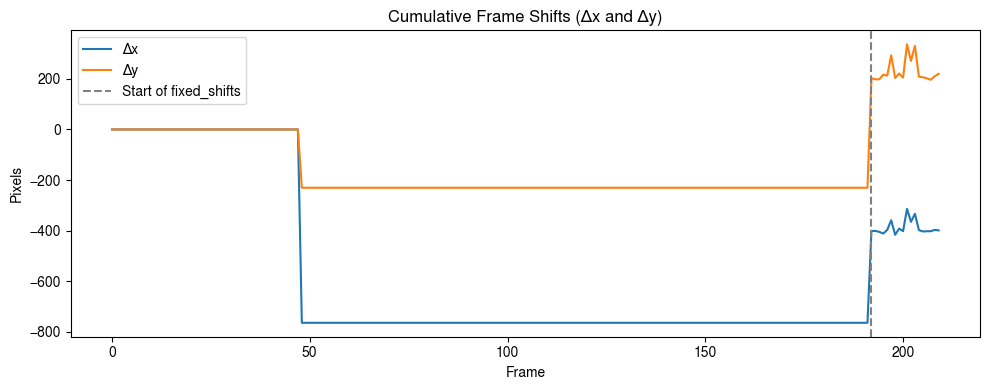

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(shifts[:, 1], label='Δx')
plt.plot(shifts[:, 0], label='Δy')
plt.axvline(192, color='grey', linestyle='--', label='Start of fixed_shifts')
plt.legend()
plt.title("Cumulative Frame Shifts (Δx and Δy)")
plt.xlabel("Frame")
plt.ylabel("Pixels")
plt.tight_layout()
plt.show()


# GET SHIFTY

In [295]:
images

dask.array<rechunk-merge, shape=(210, 4, 6911, 6911), dtype=uint16, chunksize=(10, 4, 1024, 1024), chunktype=numpy.ndarray>

In [296]:
# Lazily apply the shift frame-by-frame
images_shifted = da.stack([
    da.map_blocks(
        lambda img, dy=dy, dx=dx: ndi_shift(img, shift=(0, -dy, -dx), order=1, mode='nearest'),
        images[t],
        dtype=images.dtype
    )
    for t, (dy, dx) in enumerate(shifts)
])

segmentation_shifted = da.stack([
    da.map_blocks(
        lambda seg, dy=dy, dx=dx: ndi_shift(seg, shift=(-dy, -dx), order=0, mode='nearest'),
        segmentation[t],
        dtype=segmentation.dtype
    )
    for t, (dy, dx) in enumerate(shifts)
])

In [80]:
images_shifted

dask.array<stack, shape=(210, 4, 6911, 6911), dtype=uint16, chunksize=(1, 4, 1024, 1024), chunktype=numpy.ndarray>

In [81]:
segmentation_shifted

dask.array<stack, shape=(210, 6911, 6911), dtype=uint16, chunksize=(1, 6911, 6911), chunktype=numpy.ndarray>

In [83]:
segmentation_shifted_loaded = []
for frame in tqdm(segmentation_shifted, total = 210):
    frame = frame.compute()
    segmentation_shifted_loaded.append(frame)

  0%|          | 0/210 [00:00<?, ?it/s]

In [85]:
segmentation_shifted_loaded = np.stack(segmentation_shifted_loaded, axis = 0)

In [86]:
# v = napari.Viewer(title = 'testing shift')
# v.add_image(test_images, channel_axis = 1)
viewer.add_labels(segmentation_shifted_loaded)

<Labels layer 'segmentation_shifted_loaded' at 0x7fb9e3fefaf0>

In [ ]:
images_shifted_loaded = []
for frame in tqdm(images_shifted, total = 210):
    frame = frame.compute()
    images_shifted_loaded.append(frame)

  0%|          | 0/210 [00:00<?, ?it/s]

In [ ]:
images_shifted_loaded = np.stack(images_shifted_loaded, axis = 0)

## Shift the tracks

In [172]:
def apply_shifts_to_tracks(df, shifts):
    """Apply spatial alignment shifts to a tracking DataFrame."""
    df = df.copy()
    shift_array = shifts[df["t"].values]  # shape (N, 2): [dy, dx] per track row
    df["y"] = df["y"] - shift_array[:, 0]  # Apply dy
    df["x"] = df["x"] - shift_array[:, 1]  # Apply dx
    return df


In [236]:
zarr_dir = Path('/mnt/DATA3/BPP0050/live_1.zarr/3_4')

zarr_root = zarr.open_group(zarr_dir, mode='r')

live_1_images = da.asarray(zarr_root["images"]["0"].images)

live_1_images

live_1_segmentation = da.asarray(zarr_root["labels"]["trackastra_labels"]["0"])

live_1_segmentation

tracks_path = Path(zarr_dir / 'labels/trackastra_labels/tables/track/')
# Load and filter track table
track_columns = [f.name for f in tracks_path.iterdir() if f.is_dir()]
track_data = {
    col: zarr.open(tracks_path / col, mode='r')[:]
    for col in track_columns
}
live_1_tracks = pd.DataFrame(track_data)
live_1_tracks

zarr_dir = Path('/mnt/DATA3/BPP0050/live_2.zarr/3_4') 

zarr_root = zarr.open_group(zarr_dir, mode='r')

live_2_images = da.asarray(zarr_root["images"]["0"].images) 

live_2_images

live_2_segmentation = da.asarray(zarr_root["labels"]["trackastra_labels"]["0"])

live_2_segmentation

tracks_path = Path(zarr_dir / 'labels/trackastra_labels/tables/track/')
# Load and filter track table
track_columns = [f.name for f in tracks_path.iterdir() if f.is_dir()]
track_data = {
    col: zarr.open(tracks_path / col, mode='r')[:]
    for col in track_columns
}
live_2_tracks = pd.DataFrame(track_data)


In [237]:
# Step 0 — Realign live_2 time indices to follow live_1
live_2_tracks["t"] += live_1_tracks['t'].max() + 1  # ensures continuity

# Step 1 — Apply global shifts
aligned_live_2_tracks = apply_shifts_to_tracks(live_2_tracks, shifts)

# Step 2 — Extend tracks forward from final frame to 210
final_frame = aligned_live_2_tracks['t'].max()
final_tracks = aligned_live_2_tracks[aligned_live_2_tracks['t'] == final_frame]

extension_frames = np.arange(final_frame + 1, 210)
extended_tracks = []

final_shift = shifts[final_frame]

for t in range(final_frame + 1, 210):
    # Calculate the delta *relative* to final_frame
    shift_dy, shift_dx = shifts[t] - final_shift

    df = final_tracks.copy()
    df['t'] = t
    df['y'] -= shift_dy
    df['x'] -= shift_dx

    extended_tracks.append(df)


# Combine extended and original aligned tracks
if extended_tracks:
    extended_tracks_df = pd.concat(extended_tracks, ignore_index=True)
    aligned_live_2_tracks = pd.concat([aligned_live_2_tracks, extended_tracks_df], ignore_index=True)

# Combine both live_1 and realigned+extended live_2 tracks
all_aligned_tracks = pd.concat([live_1_tracks, aligned_live_2_tracks], ignore_index=True)


In [238]:
napari_tracks = all_aligned_tracks[['label_id', 't', 'y', 'x']]
viewer.add_tracks(napari_tracks)

<Tracks layer 'Tracks [13]' at 0x7fb9f4d69390>

In [241]:
len(all_aligned_tracks[all_aligned_tracks['t'] == 209]['track_id'].unique())

1394

# todo: load images and check if linking works 

# Previous approach

In [11]:
undo_shift = -shift_observed
# Apply the translation to the relevant slice
corrected = bf_dapi_images.copy()
print('duplicated')
for i in tqdm(range(48, corrected.shape[0]), total = len(range(48, corrected.shape[0]))):
    corrected[i] = shift(bf_dapi_images[i], shift=undo_shift, order=0, mode='nearest')

duplicated


  0%|          | 0/161 [00:00<?, ?it/s]

In [12]:
corrected_masks = masks_extended.copy()
    
print('duplicated')
for i in tqdm(range(48, corrected_masks.shape[0]), total = len(range(48, corrected_masks.shape[0]))):
    corrected_masks[i] = shift(masks_extended[i], shift=undo_shift, order=0, mode='nearest')


duplicated


  0%|          | 0/161 [00:00<?, ?it/s]

In [15]:
bf_dapi_images_corrected = np.load('/mnt/DATA3/BPP0050/temp_alignment/bf_dapi_images_corrected.npy')

In [13]:
viewer = napari.Viewer(title = 'linking')

In [14]:
viewer.add_labels(corrected_masks)
viewer.add_image(bf_dapi_images)

<Image layer 'bf_dapi_images' at 0x7eeb741466e0>

In [16]:
viewer.add_image(bf_dapi_images_corrected)

<Image layer 'bf_dapi_images_corrected' at 0x7eeb838ef220>

In [130]:
np.save('/mnt/DATA3/BPP0050/temp_alignment/bf_dapi_images_corrected.npy', corrected)
np.save('/mnt/DATA3/BPP0050/temp_alignment/masks_extended_corrected.npy', corrected_masks)


In [7]:
import numpy as np
from scipy.stats import mode
from skimage.measure import regionprops
from tqdm.auto import tqdm

def relabel_with_previous_overlap(masks):
    relabeled = masks.copy()

    for t in tqdm(range(48, masks.shape[0]), desc="Relabeling masks"):
        prev_frame = relabeled[t - 1]
        curr_frame = relabeled[t]

        new_frame = np.zeros_like(curr_frame)

        # For each region in current frame
        for region in regionprops(curr_frame):
            label = region.label
            coords = region.coords

            # Find overlapping labels in previous frame
            prev_labels = prev_frame[tuple(coords.T)]

            # Get the most frequent overlapping label (excluding 0)
            overlapping_labels = prev_labels[prev_labels > 0]

            if overlapping_labels.size > 0:
                new_label = mode(overlapping_labels, keepdims=False).mode
            else:
                new_label = label + 10000  # Assign a new, distinct label

            new_frame[tuple(coords.T)] = new_label

        relabeled[t] = new_frame

    return relabeled



In [8]:
relabelled_masks = relabel_with_previous_overlap(corrected_masks)

Relabeling masks:   0%|          | 0/161 [00:00<?, ?it/s]

In [18]:
viewer.add_labels(relabelled_masks)

<Labels layer 'relabelled_masks' at 0x7eeb81d29e10>

In [9]:
np.save('/mnt/DATA3/BPP0050/temp_alignment/masks_extended_corrected_relabelled.npy', relabelled_masks)


In [17]:
relabelled_masks = np.load('/mnt/DATA3/BPP0050/temp_alignment/masks_extended_corrected_relabelled.npy')

In [138]:

num_segments = len(regionprops(relabelled_masks[48]))
print("Segments in frame 48:", num_segments)


Segments in frame 48: 1032


In [139]:
len(regionprops(relabelled_masks[47]))

1720

In [137]:
len(np.unique(relabelled_masks[48]))

1033

# Adding intermediatary frame 

### shift intermediate frame?

In [64]:
intermed_dapi_frame.shape, undo_shift

((6911, 6911), array([227.46747491, 764.43987469]))

In [63]:

intermed_dapi_frame = shift(intermed_dapi_frame[0], shift=undo_shift, order=0, mode='nearest')

intermed_frame = shift(intermed_frame[0], shift=undo_shift, order=0, mode='nearest')


In [65]:
intermed_dapi_frame = np.expand_dims(
    intermed_dapi_frame,
    axis=0
)

intermed_frame = np.expand_dims(
    intermed_frame,
    axis=0
)


In [24]:
viewer.add_image(intermed_frame)

<Image layer 'intermed_frame' at 0x7eeb8202ee60>

In [24]:
# Step 1: remove the previous incorrect frame (at index 192)
relabelled_masks = np.delete(relabelled_masks, 192, axis=0)

# Step 2: insert the corrected intermed_frame at index 192
relabelled_masks = np.concatenate([
    relabelled_masks[:192],
    intermed_frame,
    relabelled_masks[192:]
], axis=0)


In [22]:
# Insert between frames 191 and 192
bf_dapi_images_corrected = np.concatenate([
    bf_dapi_images_corrected[:192],         # up to and including frame 191
    intermed_frame,          # the new frame
    bf_dapi_images_corrected[192:]          # from frame 192 onwards
], axis=0)
# Duplicate the last frame and append it
print('interleaving')
last_frame = relabelled_masks[-1:]
relabelled_masks = np.concatenate([relabelled_masks, last_frame], axis=0)


interleaving


In [66]:
# bf_dapi_images_corrected_dapi_intermed_frame = bf_dapi_images_corrected
bf_dapi_images_corrected_dapi_intermed_frame[192] = intermed_dapi_frame

In [ ]:
bf_dapi_2ch = np.stack([bf_dapi_images_corrected_dapi_intermed_frame, bf_dapi_images_corrected], axis = 1)

In [67]:
bf_dapi_images_corrected[192] = intermed_frame

In [ ]:
# viewer = napari.Viewer(title ='linking')

viewer.add_image(bf_dapi_2ch, channel_axis = 1)
# viewer.add_labels(relabelled_masks)

In [31]:
viewer = napari.Viewer(title = 'looking for link')

In [36]:
viewer.add_image(bf_dapi_images[190])

<Image layer 'Image [2]' at 0x7feda8c5c4f0>

In [39]:
viewer.add_image(intermed_frame)

<Image layer 'intermed_frame' at 0x7fed9ff218a0>

In [33]:
viewer.add_labels(relabelled_masks[191])

<Labels layer 'Labels' at 0x7feda91a59c0>

In [41]:
viewer.layers['Points'].data

array([[   0.        , 5184.46538947, 2570.41067026],
       [   0.        , 5582.66295744, 2937.24103403]])

In [45]:
live_2_fix_coords = viewer.layers['Points'].data
live_2_fix_coords

array([[ 191.        , 2732.88632183, 2325.75471556],
       [ 192.        , 2926.36920266, 1933.48805306],
       [ 191.        , 2282.30975005, 4279.13667677],
       [ 192.        , 2475.79263087, 3886.87001428]])

# Create tracking

In [ ]:
records = []
label_stack = masks_live_1
# Loop over timepoints
for t in tqdm(range(label_stack.shape[0]), desc="Extracting coordinates"):
    labeled_img = label_stack[t]
    for region in regionprops(labeled_img):
        records.append([region.label, t, region.centroid[0], region.centroid[1]])

# Create DataFrame with desired column order
tracks_live_1 = pd.DataFrame(records, columns=["ID", "T", "Y", "X"])

records = []
label_stack = masks_live_2
# Loop over timepoints
for t in tqdm(range(label_stack.shape[0]), desc="Extracting coordinates"):
    labeled_img = label_stack[t]
    for region in regionprops(labeled_img):
        records.append([region.label, t, region.centroid[0], region.centroid[1]])

# Create DataFrame with desired column order
tracks_live_2 = pd.DataFrame(records, columns=["ID", "T", "Y", "X"])